# Introduction

Welcome to the Eureka! tutorial - today we will learn how to run Eureka!'s S3 data reduction module, which takes 2D JWST data and reduces it to 1D spectra.

Eureka! is an open-source python package available for download at https://github.com/kevin218/Eureka (lead developers are Sebastian Zieba, Kevin Stevenson, and Laura Kreidberg).

## Goals
- walk through all the major steps in data reduction
- get comfortable with the Eureka! structure and syntax
- most importantly, make sure none of the steps are a black box.

## Import standard python packages and Eureka!

In [16]:
import sys, os, time                                                            
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload                                                    
import eureka.S3_data_reduction.s3_reduce as s3                                 
from eureka.lib import readECF as rd                                            
from eureka.lib import logedit                                                  
from eureka.lib import readECF as rd                                            
from eureka.lib import manageevent as me                                        
from eureka.S3_data_reduction import optspex                                    
from eureka.lib import astropytable                                             
from eureka.lib import util                                                     
from eureka.S3_data_reduction import plots_s3

### Step 0: Initialization 

In [17]:
# Starts timer to monitor how long data reduction takes
t0      = time.time()

# Names the event (has to match the event name used for the *.ecf files)
eventlabel = 'wasp43b'                                                          
                                                                                
# Initialize metadata object to store all extra information 
# related to the event and the data reduction 

meta              = s3.Metadata()                                                 
meta.eventlabel   = eventlabel                                                    
                                                                                
# Initialize data object to store data from the observation                                                       
dat              = s3.Data()   

Try printing how much time has passed since the timer was initialized. Run the cell again. Do you see the time change?

In [19]:
print(time.time() - t0)  #time elapsed since the timer start

7.827232122421265


In [20]:
# Load Eureka! control file and store values in Metadata object                    
ecffile = 'S3_' + eventlabel + '.ecf'                                           
ecf     = rd.read_ecf(ecffile)                                                  
rd.store_ecf(meta, ecf)  

Information from the ECF ("Eureka control file") is now stored in a Metadata object. This includes all the high level information about the data reduction (which JWST instrument was used? do we want to display plots? where is the data stored? what size is the extraction window? etc.)

To see the current contents of the Metadata object, type ``meta.__dict__.keys``. 

What is the value of ``meta.bg_deg``? Can you change it?

### Step 1: Make directories to store reduced data, create log file, read in data

In [21]:
# Create directories for Stage 3 processing                                     
datetime= time.strftime('%Y-%m-%d_%H-%M-%S')                                    
meta.workdir = 'S3_' + datetime + '_' + meta.eventlabel                             
if not os.path.exists(meta.workdir):                                              
    os.makedirs(meta.workdir)                                                     
if not os.path.exists(meta.workdir+"/figs"):                                      
    os.makedirs(meta.workdir+"/figs")                                             
                                                                                
# Load instrument module                                                        
exec('from eureka.S3_data_reduction import ' + meta.inst + ' as inst', globals()) 
reload(inst)                                                                    
                                                                                
# Open new log file                                                             
meta.logname  = './'+meta.workdir + '/S3_' + meta.eventlabel + ".log"                 
log         = logedit.Logedit(meta.logname)                                       
log.writelog("\nStarting Stage 3 Reduction")                                    
                                                                                
# Create list of file segments                                                  
meta = util.readfiles(meta)                                                         
num_data_files = len(meta.segment_list)                                           
log.writelog(f'\nFound {num_data_files} data file(s) ending in {meta.suffix}.fits')
                                                                                
stdspec = np.array([])


Starting Stage 3 Reduction

Found 21 data file(s) ending in calints.fits


*Important check!* Were the correct files read in? They are stored in ``meta.segment_list``.

### Step 2: read the data (and look at it!)

In [22]:
# pick a single file to read and reduce as a test
m = 17

# Read in data frame and header                                             
log.writelog(f'Reading file {m+1} of {num_data_files}')                     
dat = inst.read(meta.segment_list[m], dat, returnHdr=True)

Reading file 18 of 21


#### What data are we using?

The full description of the data is available [here](https://stsci.app.box.com/s/8r6kqh9m53jkwkff0scmed6zx42g307e/file/804595804746)). To quickly summarize, we are using simulated NIRCam grism time series data from the ERS Simulated Spectra Team.  The simulation assumes a WASP-43 b-like planet with physically realistic spectral features added. The simulated data are based on the following observational design:

- GRISMR+F322W2 pupil and filter
- RAPID readout mode
- 19 Groups per integrations
- 1287 integrations
- 1 Exposure
- 4 Output amplifiers
The data themselves are divided into “segments,” with each individual segment (seg001, seg002, etc.) containing a subset of the overall dataset. This is how flight data will be delivered. The segments are numbered in their order of observation.

We will use the Stage 2 Output from the [JWST data reduction pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/stages.html). For NIRCam, Stage 2 consists of the flat field correction, WCS/wavelength solution, and photometric calibration (counts/sec -> MJy). Note that this is specifically for NIRCam: the steps in Stage 2 change a bit depending on the instrument. The Stage 2 outputs are rougly equivalent to a “flt” file from HST.

The files have the suffix ``/*calints.fits`` which contain fully calibrated images (MJy) for each individual integration. This is the one you want if you’re starting with Stage 2 and want to do your own spectral extraction.

### Let's take a look at the data!
What is stored in the data object?

In [23]:
print(dat.__dict__.keys())

dict_keys(['mhdr', 'shdr', 'intstart', 'intend', 'data', 'err', 'dq', 'wave', 'v0', 'int_times'])


The calibrated 2D data, error array, data quality are stored in `data`, `err`, and `dq`. `wave` is the wavelength. 

The header information is stored in mhdr (main header) and shdr (science header). Use the headers to check whether the data is really from NIRCam.

In [28]:
dat.mhdr['INSTRUME']

'NIRCAM'

What units are the data stored in?

In [29]:
dat.shdr['BUNIT']

'MJy/sr'

#### What does the data look like??

Text(0, 0.5, 'spatial direction')

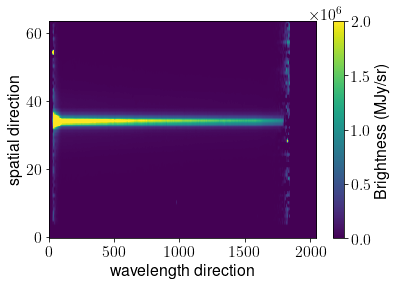

In [11]:
plt.imshow(dat.data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=2e6)
ax = plt.gca()
plt.colorbar(label='Brightness (MJy/sr)')
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')

What happens if we change the contrast with the vmax parameter? what is the approximate background level? 

Text(0, 0.5, 'spatial direction')

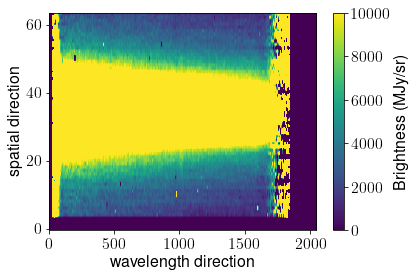

In [12]:
plt.imshow(dat.data[0], origin = 'lower', aspect='auto',  vmin=0, vmax=10000)
ax = plt.gca()
plt.colorbar(label='Brightness (MJy/sr)')
ax.set_xlabel('wavelength direction')
ax.set_ylabel('spatial direction')

How big should the extraction window be? Should it be symmetric? (Hint: we want to capture all the flux from the target star, but minimize the background)

Let's plot the spatial profile to see how wide the PSF is.

Text(0, 0.5, 'Flux (MJy/sr)')

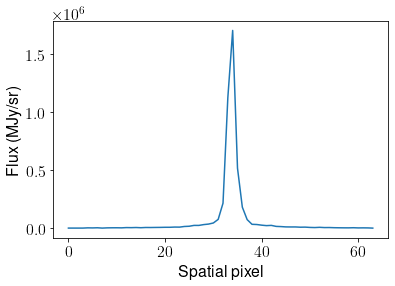

In [13]:
plt.plot(dat.data[0][:,1000]) #plots column 1000
plt.xlabel("Spatial pixel")
plt.ylabel("Flux (MJy/sr)")

Flux is mostly concentrated over a few pixels. But the wings are pretty wide! This is easier to see in log space:

<ipython-input-14-fd8aa0f2ba34>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000
<ipython-input-14-fd8aa0f2ba34>:1: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000


Text(0, 0.5, 'Log10 Flux (MJy/sr)')

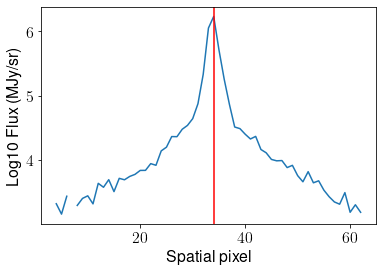

In [14]:
plt.plot(np.log10(dat.data[0][:,1000]))  #plots log10 of column 1000
ind_max = np.argmax(dat.data[0][:,1000]) #finds row where counts peak
plt.axvline(ind_max, color = 'red')      #plots peak counts
plt.xlabel("Spatial pixel")
plt.ylabel("Log10 Flux (MJy/sr)")

### Decide which parts we want to use for the background and for the spectrum¶


In [30]:
# Get number of integrations and frame dimensions                               
meta.n_int, meta.ny, meta.nx = dat.data.shape 

# Locate source postion                                                         
meta.src_xpos = dat.shdr['SRCXPOS']-meta.xwindow[0]                             
meta.src_ypos = dat.shdr['SRCYPOS']-meta.ywindow[0]   

TBC...